In [2]:
import pandas as pd
import glob
import re
import os
%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
# Here we are initializing the dictionary
# When this method is called a "count" variable is passed
# This becomes the key to the trials, and an empty dictionary
# is filled in for the corresponding value
def make_dict(count):
    
   # print("MAKING DICT")
    main_dict[count] = {
        'STIM1' : None,
        'STIM2' : None,
        'POSITION1' : None,
        'POSITION2' : None,
        'KEYPRESS'  : None,
        'TIME'      : None,
        'RESPONSE'      : None
    }


In [4]:



def parse_row(img):



# this counter is used to count the number of trials we have
# and it is used for our dictionary key
    count=0

# we start a loop iterating through the rows
# and parse out our relevant info 
    for row in img['img']:

#____________________________________________________________________________________ #   

    #check for the row w/ image (letters), and position
    # this conditional statement also iterates our "count" variable
    # and initializes a new dictionary key 
        if 'jpg' in row:
            #print(row)
            count=count+1
            ct = str(count)
            make_dict(ct)
        
        
            stim1 = row.split(" ")[1].split(".")[0]
            position1 = row.split(" ")[3].split("=")[1]
    #    print("Response1: ", response1)
     #   print("Position1: ", position1)
            stim2 = row.split(" ")[5].split(".")[0]
            position2 = row.split(" ")[7].split("=")[1]
         #   print("Response2: ", response2)
          #  print("Position2: ", position2)
            #print(count)
        
    # here we add our dictionary values 
            main_dict[ct]["STIM1"] = stim1
            main_dict[ct]["STIM2"] = stim2
            main_dict[ct]["POSITION1"] = position1
            main_dict[ct]["POSITION2"] = position2        

#____________________________________________________________________________________ #   
    # check for row with keypress and the time     
        if "time" in row:
            #print(row)
            keypress=row.split(" ")[1].split("=")[1]
    #    print(keypress)
            time=row.split(" ")[4]
        
            # here we add our dictionary values 
            main_dict[ct]["KEYPRESS"] = keypress
            main_dict[ct]["TIME"] = time 

            
#____________________________________________________________________________________ #   

     # check for row with a MISSED signal    
        if "Missed" in row: 
            keypress="Missed"
    # here we add our dictionary values 
            main_dict[ct]["KEYPRESS"] = keypress
            main_dict[ct]["TIME"] = "missed"
    #print(main_dict)


In [5]:
def get_data(file):
    print("FILENAME   " , file, "\n")
    df = pd.read_csv(file, engine='python', sep='\\t')
    df.columns=['onset', 'img', 'keypress']
    df=df.drop( columns=['keypress', 'onset'])
    # Here we grab a dataframe we call 'img', this contains the 
    # relavant column of our data we grabbed from the original df
    img = df[df['img'].str.contains("=|Missed")]
    return img 

In [6]:
def get_response():
    for key in main_dict:
        keypress = main_dict[key]['KEYPRESS']
        pos1 = main_dict[key]['POSITION1']
        pos2 = main_dict[key]['POSITION2']
        stim1 = main_dict[key]['STIM1']
        stim2 = main_dict[key]['STIM2']
        if keypress != "Missed":
           # print("KEYPRESS: ", keypress)
            if pos1 == keypress:
                response = stim1
                #print("POS1: ", pos1)
                #print("RESP1: ", resp1)
                #print("STIM: ", stim)
                main_dict[key]['RESPONSE'] = response
            if pos2 == keypress:
                response = stim2
                #print("POS2: ", pos2)
                #print("RESP2: ", resp2)
                #print("STIM: ", stim)
                main_dict[key]['RESPONSE'] = response
        else:
            main_dict[key]['RESPONSE'] = "missed"
            

In [7]:
def create_output(file):
    global stat_df 
    global r_aCount # place holder for total count of response 'a'
    global r_bCount # " " ....total count of response 'b'
    global s_aCount # " " ....total count of stimulus 'a'
    global s_bCount # " " ....total count of stimulus 'b'
    stat_df = pd.DataFrame()
    output_df = pd.DataFrame()
    responses=[]
    stims = []
  
    
    r_aCount = 0 
    r_bCount = 0
    s_aCount = 0 
    s_bCount = 0
    
    
    
    words = file.split("/")
    for word in words:
        if '.log' in word:
            filename = word
    filename = filename.split(".")[0]
    words = filename.split("_")
    for word in words:
        if re.search(r'bevel[0-9]', word):
            filename =word 
    
    
    #start a loop going over the trials, the loop currently is used to format
    #output format and get the statistics on the response and stimulus 
    for key in main_dict: 
        stim1 = main_dict[key]["STIM1"]
        stim2 = main_dict[key]["STIM2"]
        response = main_dict[key]["RESPONSE"]
        
        #this is adding relevant variables to our lists 
        stim = stim1+stim2
        stims.append(stim)
        responses.append(response)
        
        #the if statement is used to count our data-
        #a and b reponse and stimulus totals 
        if response == 'b':
            r_bCount = r_bCount + 1
        if response == 'a':
            r_aCount = r_aCount + 1
        if stim1 == "a" or stim2 == "a":
            s_aCount+=1
        if stim1 == "b" or stim2 == "b":
            s_bCount = s_bCount + 1
    
    a_posChoice = r_aCount/s_aCount * 100
    b_posChoice = r_bCount/s_bCount * 100 
    a_negChoice = 100 - a_posChoice
    b_negChoice = 100 - b_posChoice 
    a_posChoice = "%0.2f" % a_posChoice
    a_negChoice = "%0.2f" % a_negChoice
    b_posChoice = "%0.2f" % b_posChoice
    b_negChoice = "%0.2f" % b_negChoice
    
    
    output_df["STIM"] = stims
    output_df["RESPONSE"] = responses 
    output_df["PICKA"] = str(a_posChoice) + '%'
    output_df["AVOIDB"] = str(b_negChoice) + '%'
        
    stat_df["STIMULUS"] = [s_aCount, s_bCount]
    stat_df["RESPONSE"] = [r_aCount, r_bCount]
    stat_df["CHOICE"] = [float(a_posChoice), float(b_posChoice)]
    stat_df["NCHOICE"] = [float(a_negChoice), float(b_negChoice) ]
    
    
    
    print(" There are %s total 'a' responses out of %s total 'a' given stimuli, or %s %%.\
    \n There are %s total 'b' responses out of %s total 'b' given stimuli, or  %s %%." %(r_aCount, s_aCount, a_posChoice, r_bCount, s_bCount, b_posChoice))
    
  #  print(" There are %s total 'a' responses out of %s total 'a' given stimuli, or %s percent .\
   # \n There are %s total 'b' responses out of %s total 'b' given stimuli, or  %s percent." %(r_aCount, s_aCount, a_posChoice, r_bCount, s_bCount, b_posChoice))
    
   
   
    print("________________________________________" )
    print("STIMULUS COUNT A: %s \t COUNT B: %s"%(s_aCount,s_bCount))
    print("RESPONSE COUNT A: %s \t COUNT B: %s"%(r_aCount, r_bCount))
    print("________________________________________" )
    #makes columns from our lists made above and makes a new dataframe 
       
    print("----> OUTPUT DATAFRAME:")
    print(output_df.head())
    
    print("________________________________________" )

    print("----> STATISTICS DATAFRAME:")
    stat_df.rename(index={0:'a', 1:'b'}, inplace=True)
    print(stat_df.head())
    print(stat_df["CHOICE"].plot.bar(subplots=True, rot=0))
    print("\n")
    print("________________________________________" )
    print("________________________________________" )
    

    file_name = "test_csvs/%s_test.csv"%(filename)
    output_df.to_csv(file_name, index=False)
    
       
        

    
    #print(output_df.isin(["be"]))

In [8]:
def main():
    global main_dict #main dictionary is used to hold our relevant row data
    main_dict = {} 
    directory_path = input("Enter the directory: ")
    
    if not os.path.exists(os.path.join(directory_path, 'test_csvs')):
        os.makedirs(os.path.join(directory_path, 'test_csvs'))
    input_path = os.path.join(directory_path, 'test_logs', '*.log')
    
    for file in glob.glob(input_path):
        
        try:
            img_df = get_data(file) #get the relevant rows from out data and put them into a dataframe
            parse_row(img_df) #parse out variables from the rows
            get_response() #determine the response from the keypress
            create_output(file) #create output format and statistics, display data

        except pd.io.common.EmptyDataError:
            print("DATA IS EMPTY, MOVING ON")
            with open('missing_files.txt', 'a') as f:
                f.write(file)
                f.close()



Enter the directory: /Users/nikkibytes/Documents/niblunc/RW_Bevel
FILENAME    /Users/nikkibytes/Documents/niblunc/RW_Bevel/test_logs/beveltest_bevel37_2018-06-01-21_01_31_subdata.log 

 There are 17 total 'a' responses out of 28 total 'a' given stimuli, or 60.71 %.    
 There are 6 total 'b' responses out of 20 total 'b' given stimuli, or  30.00 %.
________________________________________
STIMULUS COUNT A: 28 	 COUNT B: 20
RESPONSE COUNT A: 17 	 COUNT B: 6
________________________________________
----> OUTPUT DATAFRAME:
  STIM RESPONSE   PICKA  AVOIDB
0   ac   missed  60.71%  70.00%
1   ae        a  60.71%  70.00%
2   af        a  60.71%  70.00%
3   eb        e  60.71%  70.00%
4   ae        a  60.71%  70.00%
________________________________________
----> STATISTICS DATAFRAME:
   STIMULUS  RESPONSE  CHOICE  NCHOICE
a        28        17   60.71    39.29
b        20         6   30.00    70.00


________________________________________
________________________________________
FILENAME    



________________________________________
________________________________________
FILENAME    /Users/nikkibytes/Documents/niblunc/RW_Bevel/test_logs/beveltest_bevel17_2018-04-23-17_10_40_subdata.log 

 There are 12 total 'a' responses out of 22 total 'a' given stimuli, or 54.55 %.    
 There are 11 total 'b' responses out of 26 total 'b' given stimuli, or  42.31 %.
________________________________________
STIMULUS COUNT A: 22 	 COUNT B: 26
RESPONSE COUNT A: 12 	 COUNT B: 11
________________________________________
----> OUTPUT DATAFRAME:
  STIM RESPONSE   PICKA  AVOIDB
0   fb        f  54.55%  57.69%
1   bf        f  54.55%  57.69%
2   eb        b  54.55%  57.69%
3   ad        d  54.55%  57.69%
4   ac        a  54.55%  57.69%
________________________________________
----> STATISTICS DATAFRAME:
   STIMULUS  RESPONSE  CHOICE  NCHOICE
a        22        12   54.55    45.45
b        26        11   42.31    57.69


________________________________________
_________________________________

 There are 14 total 'a' responses out of 24 total 'a' given stimuli, or 58.33 %.    
 There are 11 total 'b' responses out of 24 total 'b' given stimuli, or  45.83 %.
________________________________________
STIMULUS COUNT A: 24 	 COUNT B: 24
RESPONSE COUNT A: 14 	 COUNT B: 11
________________________________________
----> OUTPUT DATAFRAME:
  STIM RESPONSE   PICKA  AVOIDB
0   bf        f  58.33%  54.17%
1   ac        a  58.33%  54.17%
2   ad        a  58.33%  54.17%
3   ae        a  58.33%  54.17%
4   da        d  58.33%  54.17%
________________________________________
----> STATISTICS DATAFRAME:
   STIMULUS  RESPONSE  CHOICE  NCHOICE
a        24        14   58.33    41.67
b        24        11   45.83    54.17


________________________________________
________________________________________
FILENAME    /Users/nikkibytes/Documents/niblunc/RW_Bevel/test_logs/beveltest_bevel44_2018-07-05-22_04_00_subdata.log 

 There are 9 total 'a' responses out of 26 total 'a' given stimuli, or 34.62



________________________________________
________________________________________
FILENAME    /Users/nikkibytes/Documents/niblunc/RW_Bevel/test_logs/beveltest_bevel08_2018-04-16-18_07_34_subdata.log 

 There are 13 total 'a' responses out of 28 total 'a' given stimuli, or 46.43 %.    
 There are 8 total 'b' responses out of 20 total 'b' given stimuli, or  40.00 %.
________________________________________
STIMULUS COUNT A: 28 	 COUNT B: 20
RESPONSE COUNT A: 13 	 COUNT B: 8
________________________________________
----> OUTPUT DATAFRAME:
  STIM RESPONSE   PICKA  AVOIDB
0   ae   missed  46.43%  60.00%
1   fb        b  46.43%  60.00%
2   be        e  46.43%  60.00%
3   ad        d  46.43%  60.00%
4   da        a  46.43%  60.00%
________________________________________
----> STATISTICS DATAFRAME:
   STIMULUS  RESPONSE  CHOICE  NCHOICE
a        28        13   46.43    53.57
b        20         8   40.00    60.00


________________________________________
___________________________________

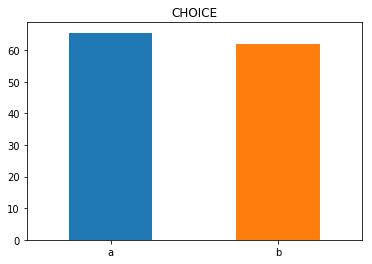

In [9]:
main()